# Time Series Prediction

In [64]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import json
import random

In [65]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

## Read in Data

In [66]:
# Read in feature data
with open('../../../data/feature_database.json') as json_database:
    database = json.load(json_database)
# Concat data
feature_data = None
for i in database:
    # Filter emission data
    if (database[i]['sector'] != 'target_values' and 
        database[i]['sector'] != 'greenhouse_emissions'):
        new_data = pd.read_json(database[i]['data'])
        if feature_data is None:
            feature_data = new_data
        else:
            feature_data = pd.concat([feature_data, new_data], axis=1, join="inner")
    else:
        print(f"Feature not used: {i}")
feature_data = feature_data.values
feature_data = feature_data.astype('float64')
print(f"Shape input features: {feature_data.shape}")
#feature_data.head()

Feature not used: E_Mio.tonnes_CO2
Feature not used: M_Mio.tonnes_CO2
Feature not used: ECO_Mio.tonnes_CO2
Feature not used: Total_CO2_Emission
Shape input features: (111, 40)


In [67]:
# Read in emission data
emission_data = pd.read_csv('../../../data/greenhouse_emissions/oeko-institut_sektorale_abgrenzung_treibhausgasemissionen_daten_sektor_monthly.csv')
emission_data = emission_data['Total_CO2_Emission'].values
emission_data = emission_data.astype('float64')
# Take only the emissions on which we have indicators
emission_data = emission_data[len(emission_data)-feature_data.shape[0]:]
print(f"Shape output data: {emission_data.shape}")


Shape output data: (111,)


0    70.152035
1    72.956128
2    75.243875
3    78.085788
4    76.184595
dtype: float64

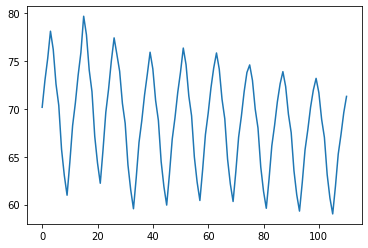

In [68]:
data= pd.Series(emission_data)
plt.plot(data)
#data = data.value[:100]
#test = data.value[100:]
data.head()

## Auto Arima Model

In [69]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(data, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=False,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=481.807, BIC=492.645, Time=0.227 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=680.183, BIC=685.602, Time=0.017 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=536.802, BIC=544.931, Time=0.100 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=567.588, BIC=575.717, Time=0.046 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=1256.327, BIC=1259.036, Time=0.007 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=419.230, BIC=432.778, Time=0.327 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=414.955, BIC=425.793, Time=0.082 seconds
Fit ARIMA(3,0,0)x(0,0,0,0) [intercept=True]; AIC=403.582, BIC=417.130, Time=0.073 seconds
Fit ARIMA(3,0,1)x(0,0,0,0) [intercept=True]; AIC=402.117, BIC=418.375, Time=0.367 seconds
Fit ARIMA(3,0,2)x(0,0,0,0) [intercept=True]; AIC=402.456, BIC=421.423, Time=0.564 seconds
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=426.8

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  111
Model:               SARIMAX(3, 0, 1)   Log Likelihood                -195.059
Date:                Wed, 05 Aug 2020   AIC                            402.117
Time:                        20:18:31   BIC                            418.375
Sample:                             0   HQIC                           408.712
                                - 111                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     22.0248      4.240      5.195      0.000      13.715      30.334
ar.L1          1.4428      0.259      5.566      0.000       0.935       1.951
ar.L2         -0.5102      0.436     -1.170      0.242      -1.365       0.344
ar.L3         -0.2540      0.237     -1.071      0.284      -0.719       0.211
ma.L1         -0.3080      0.243     -1.269      0.204      -0.784       0.168
sigma2         1.8485      0.304      6.078      0.000       1.252       2.445
===================================================================================
Ljung-Box (Q):                      365.37   Jarque-Bera (JB):                 7.53
Prob(Q):                              0.00   Prob(JB):                         0.02
Heteroskedasticity (H):               0.58   Skew:                             0.63
Prob(H) (two-sided):                  0.10   Kurtosis:                         2.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

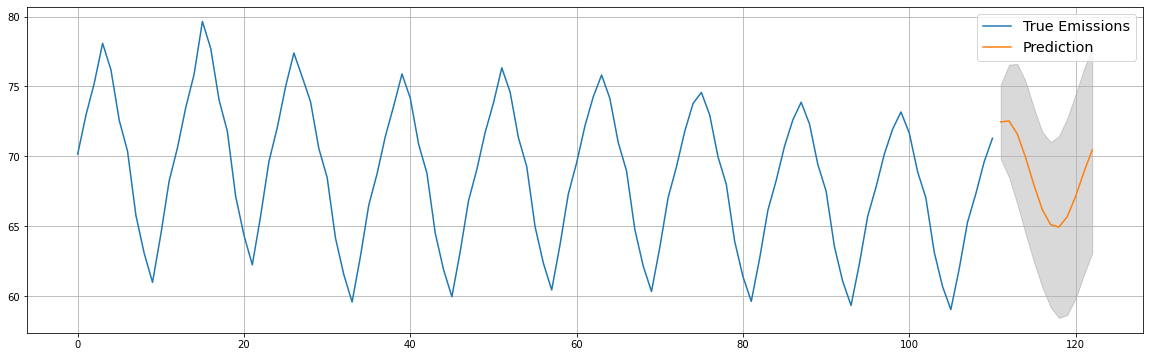

In [70]:
# Forecast
# Give the time you want to forecast here
n_periods = 12
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
#index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')
index_of_fc = np.arange(len(data), len(data)+n_periods)

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(20,6))
line1 = plt.plot(data, label='True Emissions')
line2 = plt.plot(fitted_series, label='Prediction')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.legend(fontsize='x-large')
plt.grid()
plt.xticks()
plt.show()


## Auto Sarima Model

In [71]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(data, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,1,1,12) [intercept=True]; AIC=171.520, BIC=184.445, Time=1.102 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=215.916, BIC=221.086, Time=0.040 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=191.305, BIC=201.645, Time=0.282 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=169.536, BIC=179.876, Time=0.369 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=213.941, BIC=216.526, Time=0.021 seconds
Fit ARIMA(0,1,1)x(0,1,0,12) [intercept=True]; AIC=217.829, BIC=225.583, Time=0.084 seconds
Fit ARIMA(0,1,1)x(1,1,1,12) [intercept=True]; AIC=170.303, BIC=183.228, Time=0.464 seconds
Fit ARIMA(0,1,1)x(0,1,2,12) [intercept=True]; AIC=157.295, BIC=170.220, Time=2.048 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 2, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(0,1,1)x(1,1,0,12) [intercept=True]; AIC=191.299, BIC=201.63

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  111
Model:             SARIMAX(0, 1, 0)x(0, 1, [1, 2], 12)   Log Likelihood                 -73.861
Date:                                 Wed, 05 Aug 2020   AIC                            155.722
Time:                                         20:18:42   BIC                            166.062
Sample:                                              0   HQIC                           159.905
                                                 - 111                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0041      0.031     -0.131      0.895      -0.064       0.056
ma.S.L12      -1.5367      6.589     -0.233      0.816     -14.451      11.377
ma.S.L24       0.9936      8.530      0.116      0.907     -15.726      17.713
sigma2         0.1602      1.368      0.117      0.907      -2.520       2.841
===================================================================================
Ljung-Box (Q):                       35.10   Jarque-Bera (JB):              7686.71
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               0.09   Skew:                            -5.53
Prob(H) (two-sided):                  0.00   Kurtosis:                        44.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

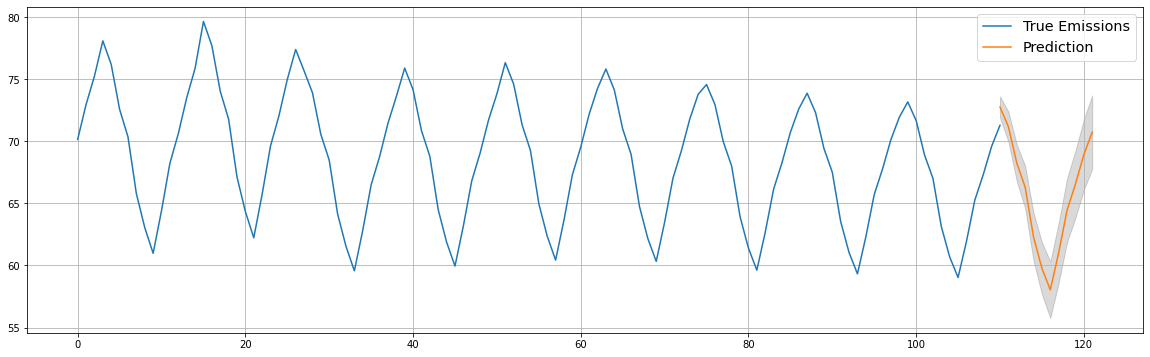

In [72]:
# Forecast
n_periods = 12
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
#index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')
index_of_fc = np.arange(len(data), len(data)+n_periods)

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot baseline, training, test and forecast
plt.figure(figsize=(20,6))
line1 = plt.plot(data, label='True Emissions')
line2 = plt.plot(fitted_series, label='Prediction')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.legend(fontsize='x-large')
plt.grid()
plt.xticks()
plt.show()

## Validate

In [73]:
#Check accuracy
data= pd.Series(emission_data)
split_train = np.arange(0, len(data)-12)
split_test = np.arange((len(data)-12), len(data))
train_data = pd.Series(data, index=split_train)
test_data = pd.Series(data, index=split_test)

In [74]:
import pmdarima as pm

# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(train_data, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,1,1,12) [intercept=True]; AIC=159.510, BIC=171.782, Time=1.804 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=201.091, BIC=206.000, Time=0.072 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=180.019, BIC=189.836, Time=0.253 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=158.633, BIC=168.450, Time=0.907 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=199.116, BIC=201.571, Time=0.020 seconds
Fit ARIMA(1,1,1)x(0,1,0,12) [intercept=True]; AIC=200.383, BIC=210.200, Time=0.510 seconds
Near non-invertible roots for order (1, 1, 1)(0, 1, 0, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(1,1,1)x(1,1,1,12) [intercept=True]; AIC=161.431, BIC=176.157, Time=1.900 seconds
N

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                   99
Model:             SARIMAX(1, 1, 1)x(0, 1, [1, 2], 12)   Log Likelihood                 -70.953
Date:                                 Wed, 05 Aug 2020   AIC                            153.906
Time:                                         20:19:03   BIC                            168.632
Sample:                                              0   HQIC                           159.832
                                                  - 99                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0038      0.039     -0.098      0.922      -0.079       0.072
ar.L1         -0.0218      3.754     -0.006      0.995      -7.380       7.336
ma.L1          0.0839      3.745      0.022      0.982      -7.256       7.424
ma.S.L12      -1.5531      3.892     -0.399      0.690      -9.182       6.076
ma.S.L24       0.9868      4.951      0.199      0.842      -8.717      10.690
sigma2         0.1770      0.878      0.202      0.840      -1.544       1.898
===================================================================================
Ljung-Box (Q):                       26.54   Jarque-Bera (JB):              5622.87
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.10   Skew:                            -5.35
Prob(H) (two-sided):                  0.00   Kurtosis:                        41.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

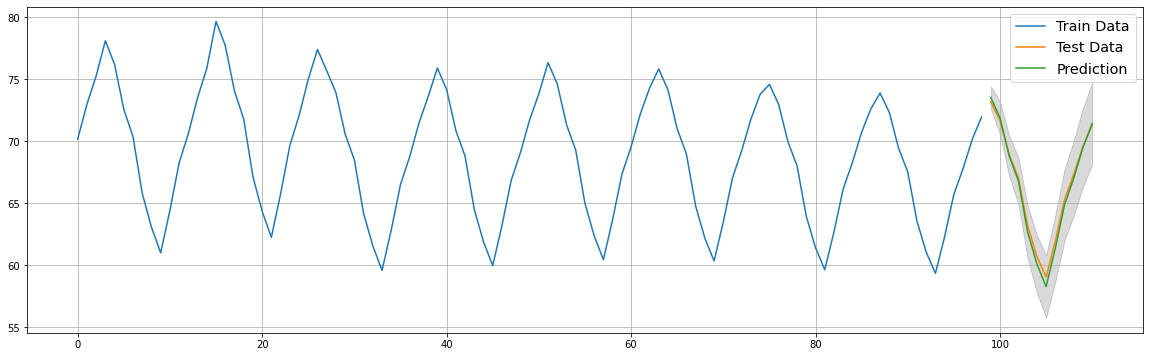

In [75]:
# Forecast
n_periods = 12
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
#index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')
index_of_fc = np.arange(len(data)-12, len(data)-12+n_periods)
index_of_test = np.arange(len(data)-12, len(data))

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
test_series = pd.Series(test_data, index=index_of_test)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot baseline, training, test and forecast
plt.figure(figsize=(20,6))
line1 = plt.plot(train_data, label='Train Data')
line3 = plt.plot(test_series, label='Test Data')
line2 = plt.plot(fitted_series, label='Prediction')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.legend(fontsize='x-large')
plt.grid()
plt.xticks()
plt.show()

In [76]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})
forecast_accuracy(fitted_series, test_data)

{'mape': 0.0055421593458581594,
 'me': -0.2397790885783717,
 'mae': 0.3550189349510268,
 'mpe': -0.003949379098821896,
 'rmse': 0.4122811993948067,
 'corr': 0.9999126921921413,
 'minmax': 0.005539257690339361}